<Center>
<h2>FAESA - CENTRO UNIVERSITÁRIO</h2>
<h1>PROJETO INTEGRADOR COMPUTAÇÃO IV</h1>

<h3>Classificação automática de postagens</h3>

</Center>

#### Importanto as bibliotecas necessárias:

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, cross_val_score, cross_validate
from sklearn.feature_selection import RFE
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer, f1_score, recall_score, precision_score
from wordcloud import WordCloud 
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

### Treinando e avaliando modelos de Aprendizagem Supervisionada
Para a classificação, foram escolhidos os modelos KNeighborsClassifier e DecisionTreeClassifier

In [2]:
models = []
models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
models.append(('KNeighborsClassifier', KNeighborsClassifier()))

representacoes = ['tf', 'idf', 'tfidf']
metricas = ['f1_micro', 'f1_macro', 'precision' , 'recall']
kfold = KFold(n_splits=10, shuffle=True)
rus = RandomUnderSampler()

scorers = {
            'precision': make_scorer(precision_score, average='weighted'),
            'recall': make_scorer(recall_score, average='macro'),
            'f1_micro': make_scorer(f1_score, average='micro'),
            'f1_macro': make_scorer(f1_score, average='macro'),
          }

In [3]:
resultados = []
modelos = []
for representacao in representacoes:
    vetorizacao_classificada = pd.read_csv('../data/classified_vectorization/classified_'+representacao+'.csv')
    x_treino, y_treino = rus.fit_resample(vetorizacao_classificada[vetorizacao_classificada.columns[:-1]].values, vetorizacao_classificada[vetorizacao_classificada.columns[-1:]].values.ravel())
    for name, model in models:
        modelos.append(representacao+'_'+name)

        outcome = y_treino
        predictor = x_treino

        # Validação cruzada
        cv_result = cross_validate(model, predictor, outcome, cv=kfold, scoring=scorers, verbose=False)
        result = []
        for metrica in scorers:
            key = "test_"+metrica;
            result.append(cv_result[key].mean())
        resultados.append(result)

#### Avaliando os modelos:

In [4]:
tabela_resultado = pd.DataFrame(data=resultados, columns=scorers.keys(), index=modelos)
tabela_resultado

,precision,recall,f1_micro,f1_macro
tf_DecisionTreeClassifier,0.939495,0.938661,0.938158,0.937955
tf_KNeighborsClassifier,0.897989,0.889995,0.890013,0.888497
idf_DecisionTreeClassifier,0.936423,0.935646,0.935271,0.935554
idf_KNeighborsClassifier,0.754114,0.730053,0.729071,0.731455
tfidf_DecisionTreeClassifier,0.945926,0.945301,0.945025,0.944788
tfidf_KNeighborsClassifier,0.756063,0.714366,0.713077,0.712401


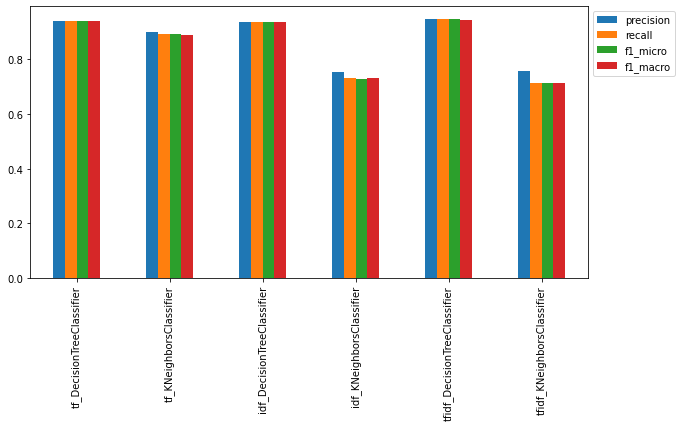

In [5]:
ax = tabela_resultado.plot.bar(figsize=(10, 5))
ax.legend(bbox_to_anchor=(1, 1))

Podemos observar que o modelo que se saiu melhor foi o <b>DecisionTreeClassifier</b> para a representação <b>TFxIDF</b>, então iremos utilizar esta composição para classificar as postagens não rotuladas.

### Classificação de novas postagens

#### Preparando datasets para teste:

In [6]:
vetorizacao_treino = pd.read_csv('../data/classified_vectorization/classified_tfidf.csv')
x_treino, y_treino = rus.fit_resample(vetorizacao_treino[vetorizacao_treino.columns[:-1]].values, vetorizacao_treino[vetorizacao_treino.columns[-1:]].values.ravel())

df_teste = pd.read_csv('../data/vectorization/new_tweets/vectorization_tfidf.csv')
x_test = df_teste[df_teste.columns].values

with open('../data/posts/new_tweets.csv', encoding="utf8") as file:
    novos_tweets = file.readlines()

#### Efetuando as classificações:

In [7]:
model = DecisionTreeClassifier()
model.fit(x_treino, y_treino)
predict = model.predict(x_test)
df_teste['rotulo'] = predict
df_teste['texto'] = novos_tweets

### Avaliação dos resultados

#### Nuvem de palavras:

In [9]:
stop_words = set(stopwords.words('portuguese'))
cv = CountVectorizer(stop_words=stop_words, max_features=200)
counts = cv.fit_transform(novos_tweets).toarray()
words = np.array(cv.get_feature_names_out())

frequencies = {}

for i, word in enumerate(words):
    frequencies[word] = 0
    for count in counts:
        frequencies[word] += count[i]

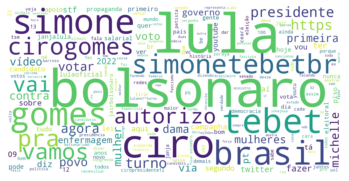

In [13]:
wc = WordCloud(background_color="white", max_words=200,
               max_font_size=256,
               random_state=42, width=1600, height=800)
wc.generate_from_frequencies(frequencies)
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

<b>Exemplos de postagens classificadas:</b>

In [28]:
pd.set_option('display.max_colwidth', None)
df_teste[df_teste['rotulo']=='positivo'].sample(1).texto

788    Vou votar no Ciro Gomes\n
Name: texto, dtype: object

In [55]:
df_teste[df_teste['rotulo']=='neutro'].sample(1).texto

129    Campanha presidencial  Pesquisa popular na internet  Lula: 90% Bolsonaro:0.09%  Simone tebet:0.08% Ciro Gomes: 0.08% Eymael: 0.06% Felipe d Ávila: 0.09 Léo Perecles: 0.06 Roberto Jeferson:0.04 Sofia Manzano: 0.06 Soraya Thronicke: 3% Verá: 1%  Lula vai eleito no 1 turno direto\n
Name: texto, dtype: object

In [62]:
df_teste[df_teste['rotulo']=='negativo'].sample(1).texto

571    Sinceramente, não estou falando isso porque sou sanguinário, cruel ou que apoio a ditadura, pelo contrário, eu sou 100% democrático, mas eu tenho uma frase a dizer: Morte a Lula e fora Bolsonaro!\n
Name: texto, dtype: object

#### Conclusões

&emsp;Podemos observar que o uso de algoritmos de machine learning compõe uma poderosa ferramenta para classificação de sentimentos em postagens nas redes sociais. Apesar de não conseguirmos mensurar precisamente a porcentagem de acertos da classificação de novas postagens (devido ao volume de dados), podemos observar que foi possível listar facilmente casos de classificação bem sucedida.<br>
&emsp;Ademais, observamos, durante o desenvolvimento, que poderíamos ter resultados melhores com uma população de posts mais bem povoada, visto que, foram extraídas do twitter um grande volume de postagens que agregaram pouco valor para a classificação, principalmente aquelas que representam respostas a outros tweets, ou que pussuiam imagens e videos importantes para o significado.
